# Download, Import and Denoise LP4 Data from FGCZ, re-demultiplexed data with correct?! barcodes

1. connect an external disk an make sure it has enough space and then use the following command:


    

wget --user meyeanni -e robots=off --ask-password -r --no-parent -nH --cut-dirs=2 --reject="index.html*" -P "/Volumes/Extreme SSD/LP4” https://fgcz-gstore.uzh.ch/projects/p35470/o36629_NextSeq_240826_NS2k-370/

Since the run was just re-demultiplexed and not re-seqeunced, all the run details remain the same:
In FGCZ SUSHI - check out the MultiQC report (→ Datasets → Fastq QC →
multiQC report link) https://fgcz-gstore.uzh.ch/projects/p35470/o35874_Fastqc_2024-09-02--19-52-24/FastQC_Result/multiqc_report.html

-> looked fine:

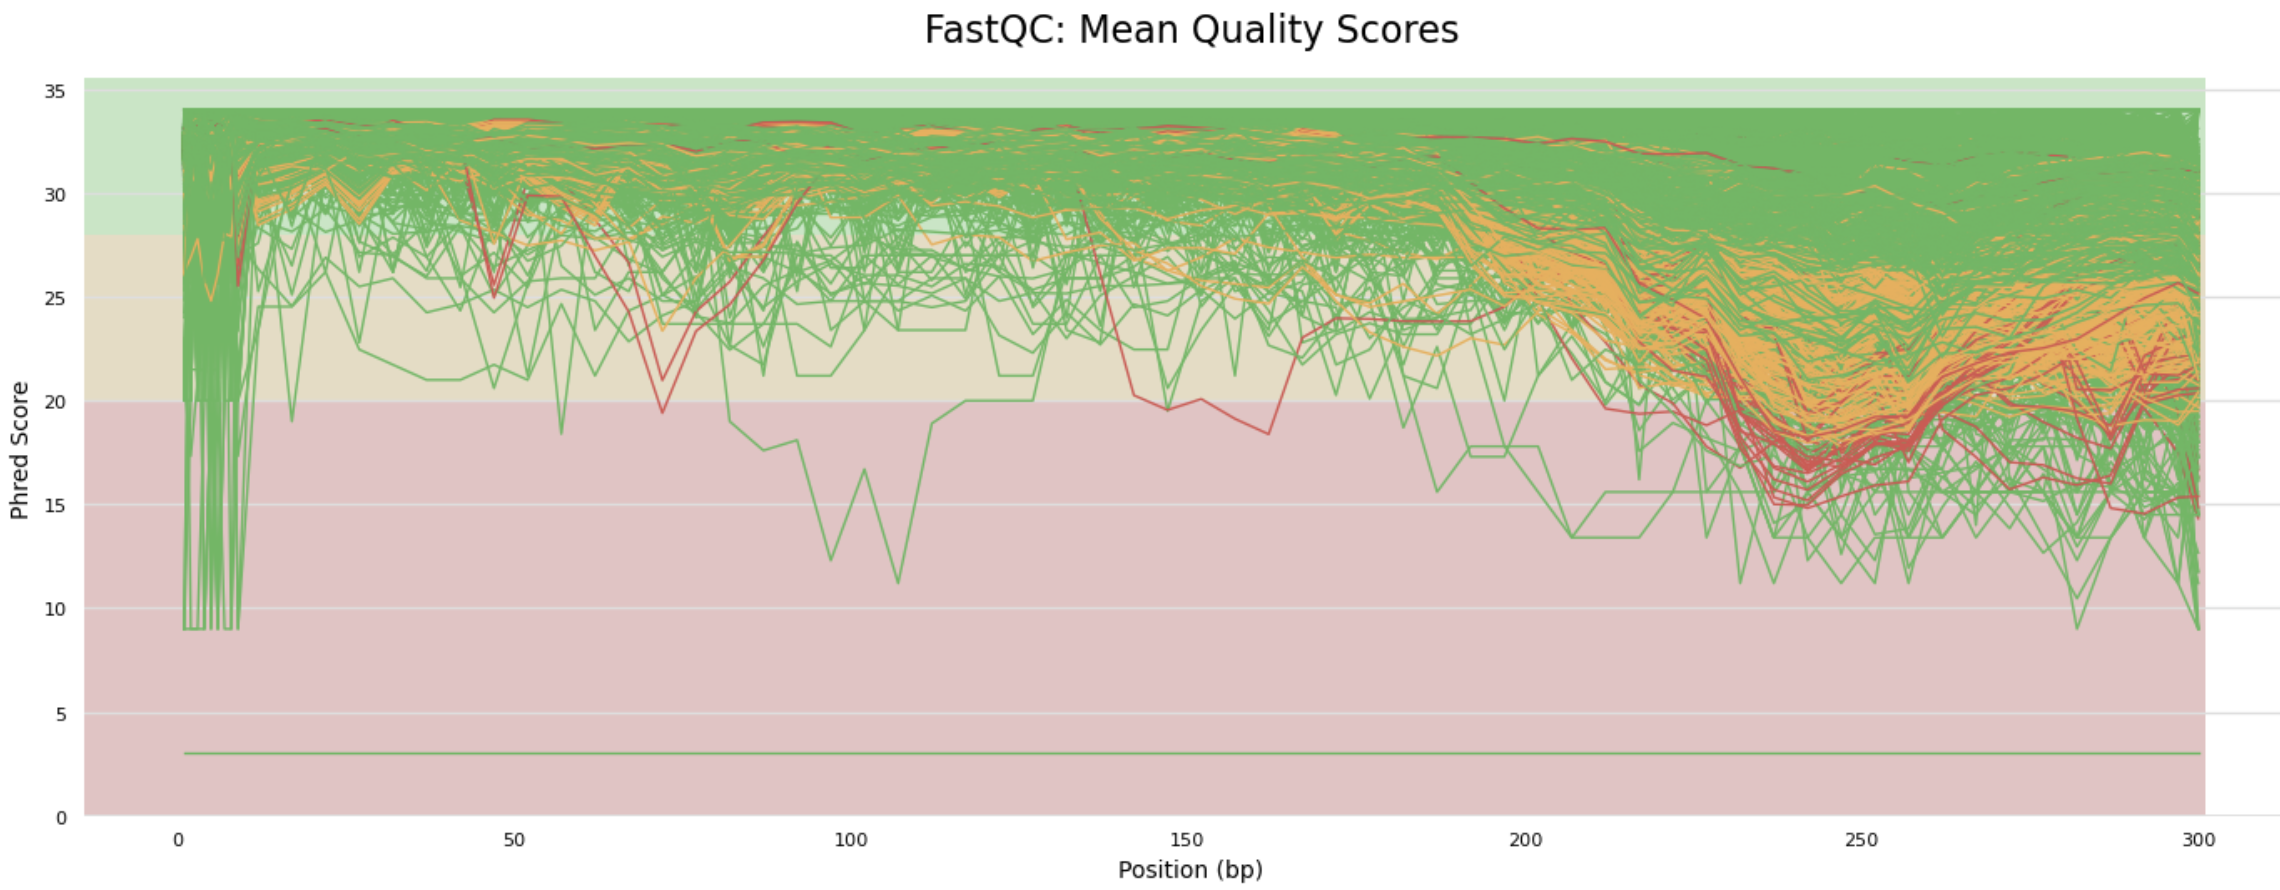

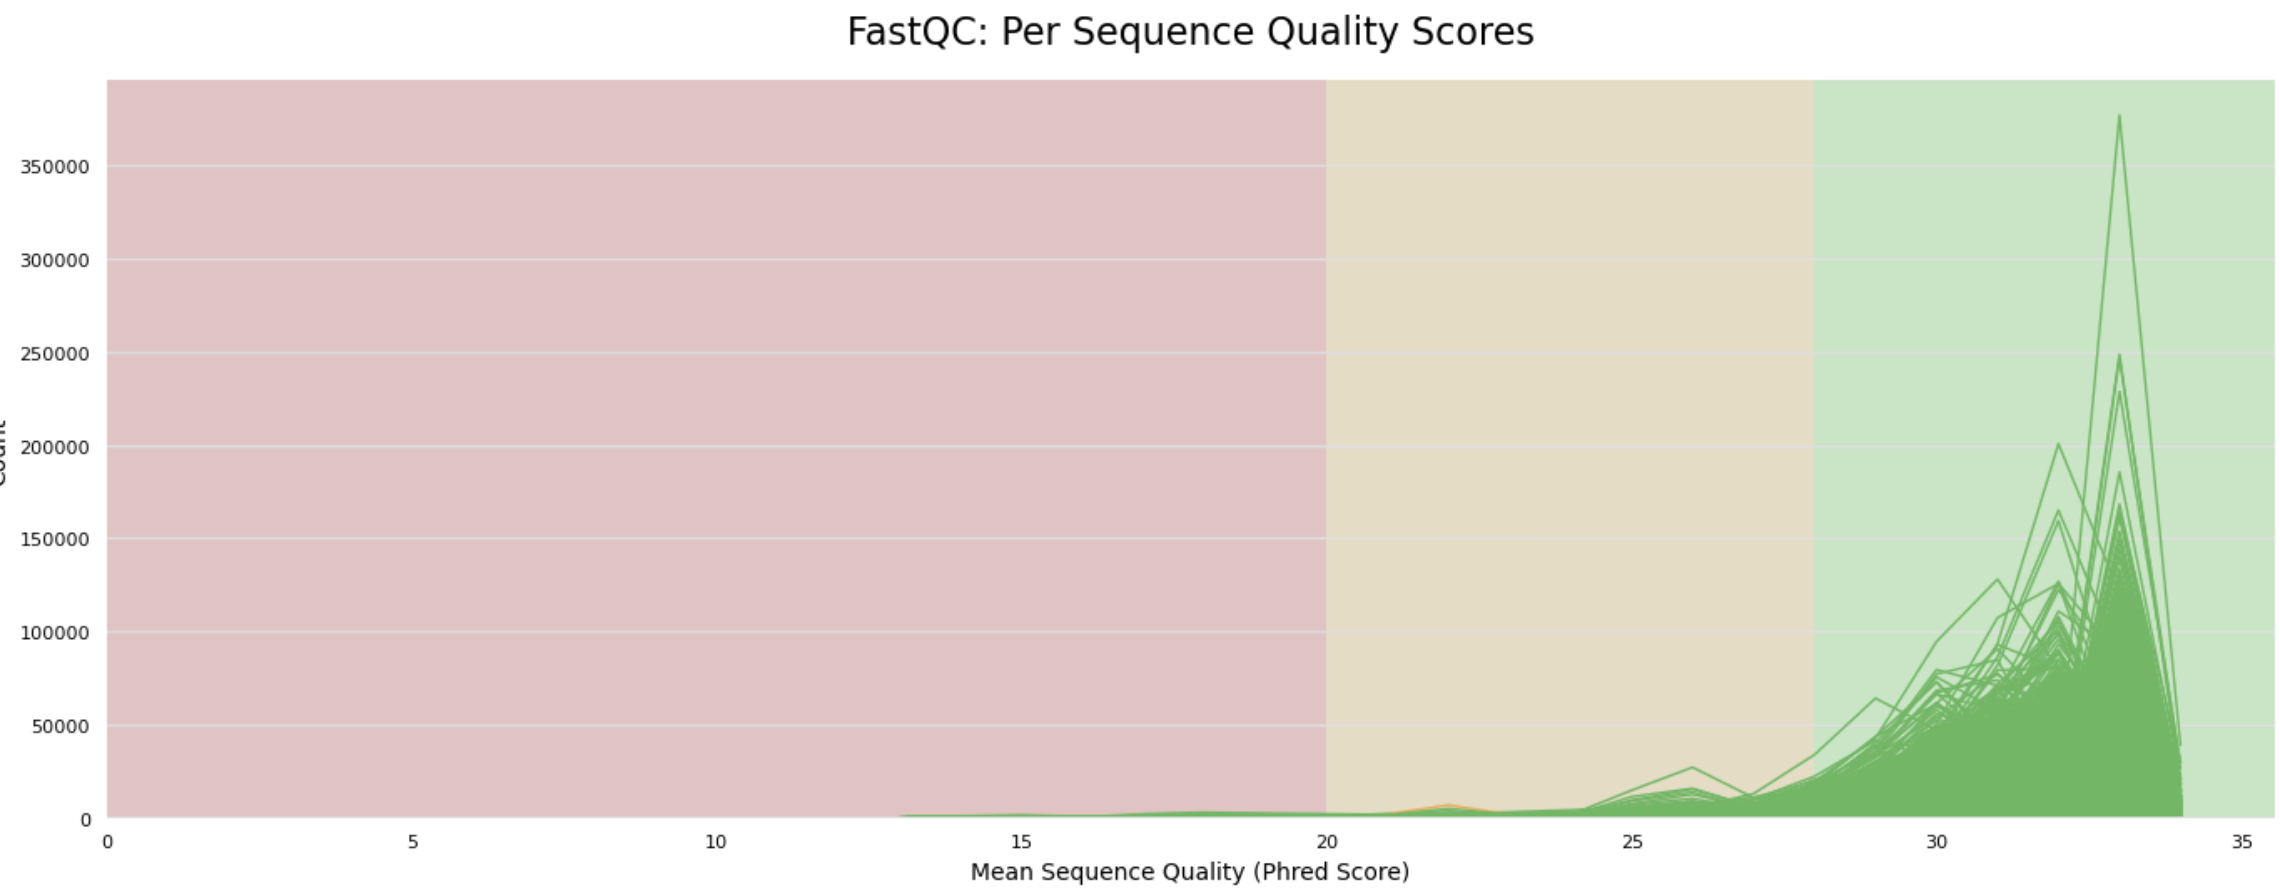

4. Transfer downloaded fastq.gz files to the HEST cloud under /home/meyeanni/cloud/meyeanni/LP4 as well as to the group NAS (Data folder)


In [ ]:
#transfer sequences first in new folder called seqs, then run following command in terminal to transfer all seqs to the cloud:
scp -r /Volumes/Extreme\ SSD/LP4/o36629_NextSeq_240826_NS2k-370/seqs meyeanni@g-wst-fsbt-meta:/home/meyeanni/cloud/meyeanni/LP4

#to be sure that it is not messed up with anything (since I had to upload it several times due to bad internet and server connection interruptions), -->> make new 
#folder called o36629_NextSeq_240826_NS2k-370_new and move the seqs folder in this one:

mkdir -p /home/meyeanni/cloud/meyeanni/LP4/o36629_NextSeq_240826_NS2k-370_new
mv /home/meyeanni/cloud/meyeanni/LP4/seqs /home/meyeanni/cloud/meyeanni/LP4/o36629_NextSeq_240826_NS2k-370_new/

#then count the files just to see if everything was moved:

ls -1 /home/meyeanni/cloud/meyeanni/LP4/o36629_NextSeq_240826_NS2k-370_new/seqs | wc -l
#4450 files, that's correct



folder o36629_NextSeq_240826_NS2k-370_new/seqs/ contains the
demultiplexed fastq.gz files (forward and reverse read of each sample)
e.g. 357316_540-LP4-16S-0540_S1858_R1_001.fastq.gz and
357316_540-LP4-16S-0540_S1858_R2_001.fastq.gz

In [ ]:
#tar -xf o35731_NextSeq_240722_NS2k-350.tar

6. Add a Lane number: To import with Casava1.8 first add a Lane
number (since it's a full flow cell this is not specified yet)

In [ ]:
#bash:
#~/home/meyeanni/cloud/meyeanni/LP4/o36629_NextSeq_240826_NS2k-370_new/seqs
# Loop through all fastq.gz files in the directory
 # Use sed to extract and modify the filename
# Rename the file
for file in *.fastq.gz; do
  base_name=$(echo "$file" | sed -E 's/(.*)(_R[12]_001\.fastq\.gz)/\1_L001\2/')
  mv "$file" "$base_name"
done


for file in *.fastq.gz; do
  base_name=$(echo "$file" | sed -E 's/(.*)(_R[12]_001\.fastq\.gz)/\1_L001\2/')
  mv "$file" "$base_name"
done



⟶ files now are called e.g. 357316_540-LP4-16S-
0540_S1858_L001_R2_001.fastq.gz

7. Split the reads to respective folders: move the files to import fungal and
bacterial data seperately and count files per folder:

In [ ]:


# Create the folders where we'll move the files
mkdir -p ITS
mkdir -p 16S

# Initialize counters
count_ITS=0
count_16S=0

# Loop through all fastq.gz files
for file in *.fastq.gz; do
  # Check if the filename contains 'ITS'
  if [[ "$file" == *ITS* ]]; then
    count_ITS=$((count_ITS + 1))
    # Move the file to the ITS folder
    mv "$file" ITS/
  
  # Check if the filename contains '16S'
  elif [[ "$file" == *16S* ]]; then
    count_16S=$((count_16S + 1))
    # Move the file to the 16S folder
    mv "$file" 16S/
  fi
done

# Output the counts
echo "Number of ITS files: $count_ITS"
echo "Number of 16S files: $count_16S"


mkdir -p ITS
mkdir -p 16S
count_ITS=0
count_16S=0


for file in *.fastq.gz; do
  if [[ "$file" == *ITS* ]]; then
    count_ITS=$((count_ITS + 1))
    mv "$file" ITS/
  elif [[ "$file" == *16S* ]]; then
    count_16S=$((count_16S + 1))
    mv "$file" 16S/
  fi
done
echo "Number of ITS files: $count_ITS"
echo "Number of 16S files: $count_16S"


#another way to count moved files: ls -1 | wc -l


ITS files: 2304
16S files: 2146

8. import the reads to qiime2



In [ ]:
#bash:
# we work in the latest qiime2 release!
conda activate qiime2-amplicon-2024.5
# make the respective folders
mkdir /home/meyeanni/cloud/meyeanni/LP4/artifacts
mkdir /home/meyeanni/cloud/meyeanni/LP4/artifacts/ITS
mkdir /home/meyeanni/cloud/meyeanni/LP4/artifacts/16S
cd /home/meyeanni/cloud/meyeanni/LP4/artifacts
qiime tools import \
--type 'SampleData[PairedEndSequencesWithQuality]' \
--input-path ~/public/Cloud/meyeanni/LP4/o36629_NextSeq_240826_NS2k-370_new/seqs/ITS \
--input-format CasavaOneEightSingleLanePerSampleDirFmt \
--output-path ITS/ITS-demux-paired-end.qza
qiime tools import \
--type 'SampleData[PairedEndSequencesWithQuality]' \
--input-path ~/public/Cloud/meyeanni/LP4/o36629_NextSeq_240826_NS2k-370_new/seqs/16S \
--input-format CasavaOneEightSingleLanePerSampleDirFmt \
--output-path 16S/16S-demux-paired-end.qza
# summarize the import files
qiime demux summarize --i-data ITS/ITS-demux-paired-end.qza --o-visualization ITS/ITS-demux-paired-end.qzv

qiime demux summarize --i-data 16S/16S-demux-paired-end.qza --o-visualization 16S/16S-demux-paired-end.qzv


9. check out the demux files:

*ITS*: 
check out after adapter trimming again!
for now, fwd median read quality actually does not drop below 34 (⟶
could still try trimming to 215 bp) and rev quality stays equally good (→
try trimming to 245 or 235 bp)
⟶ definitely also try just using the fwd reads since we have 300 bp
length
-> basically just do what previously tested: fw reads only and same parameters (see below)



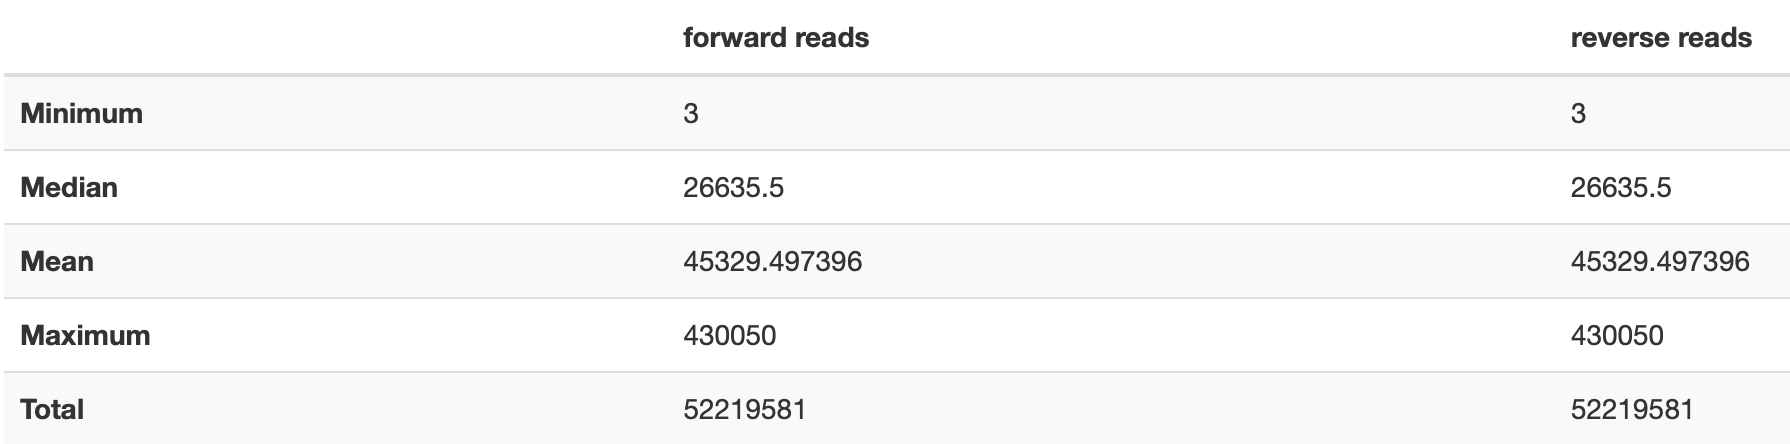

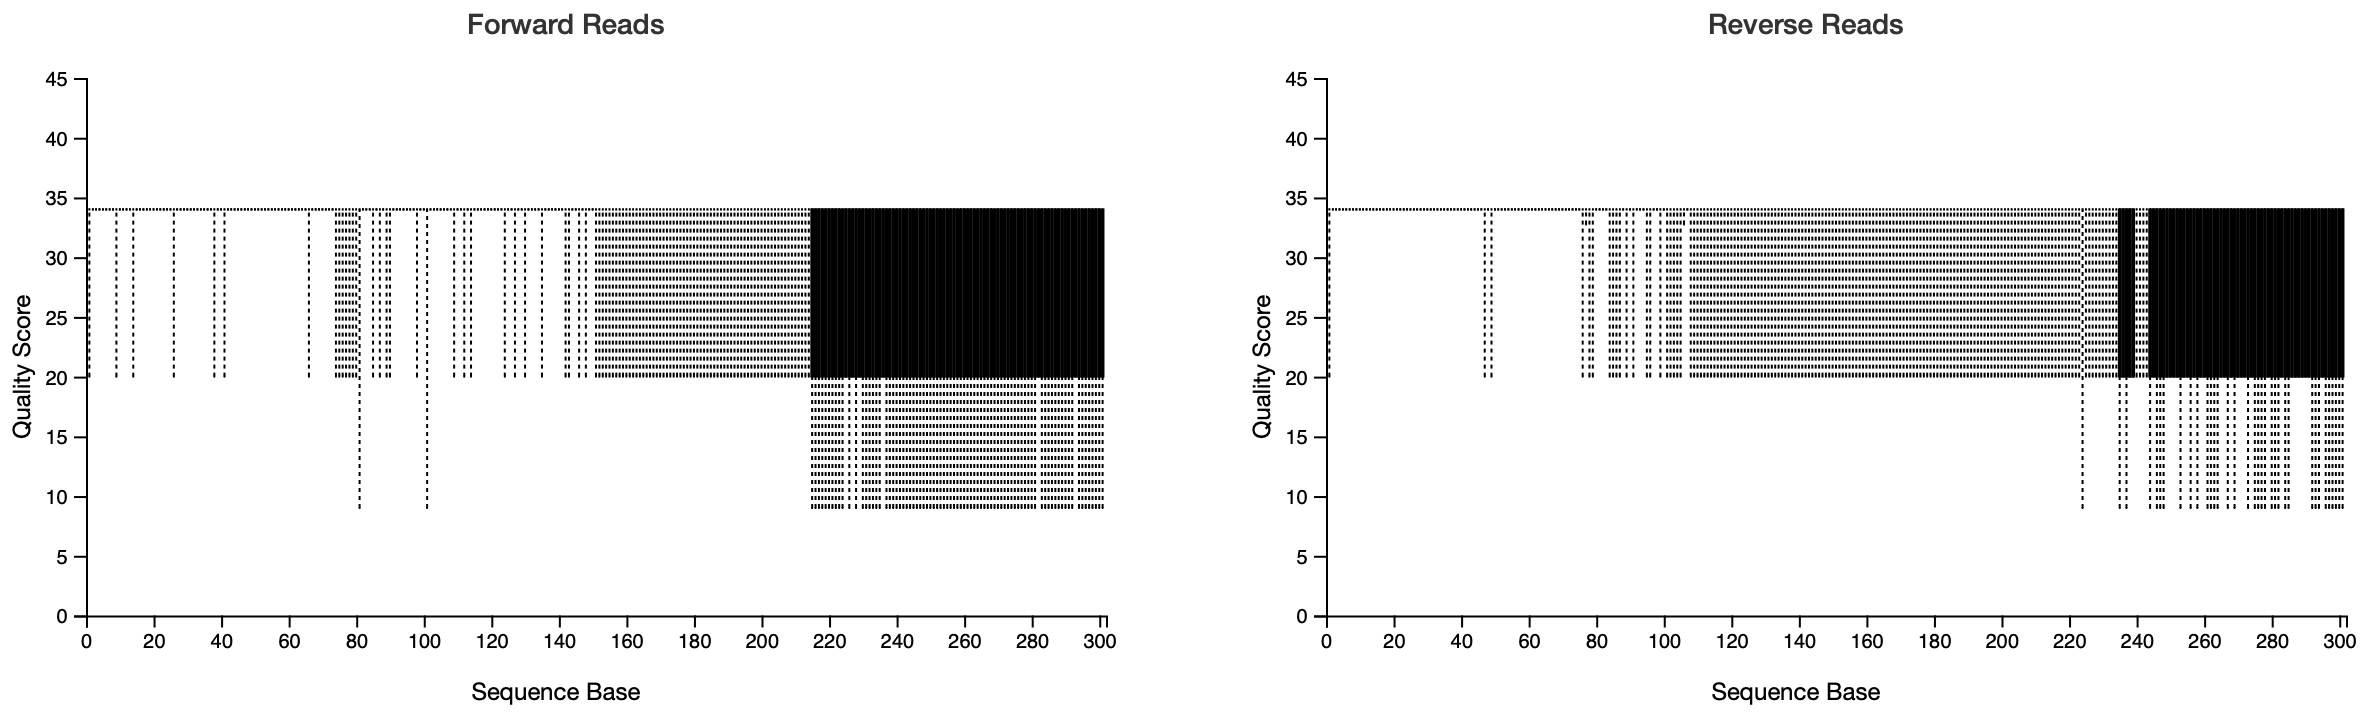

*16S*: perfect quality in the fwd, trim reverse to 250? But try also shorter not to
get more chimeras because the overlap is too long --> also here just do what previously worked best: trim to 150 bp fw and rv and merge


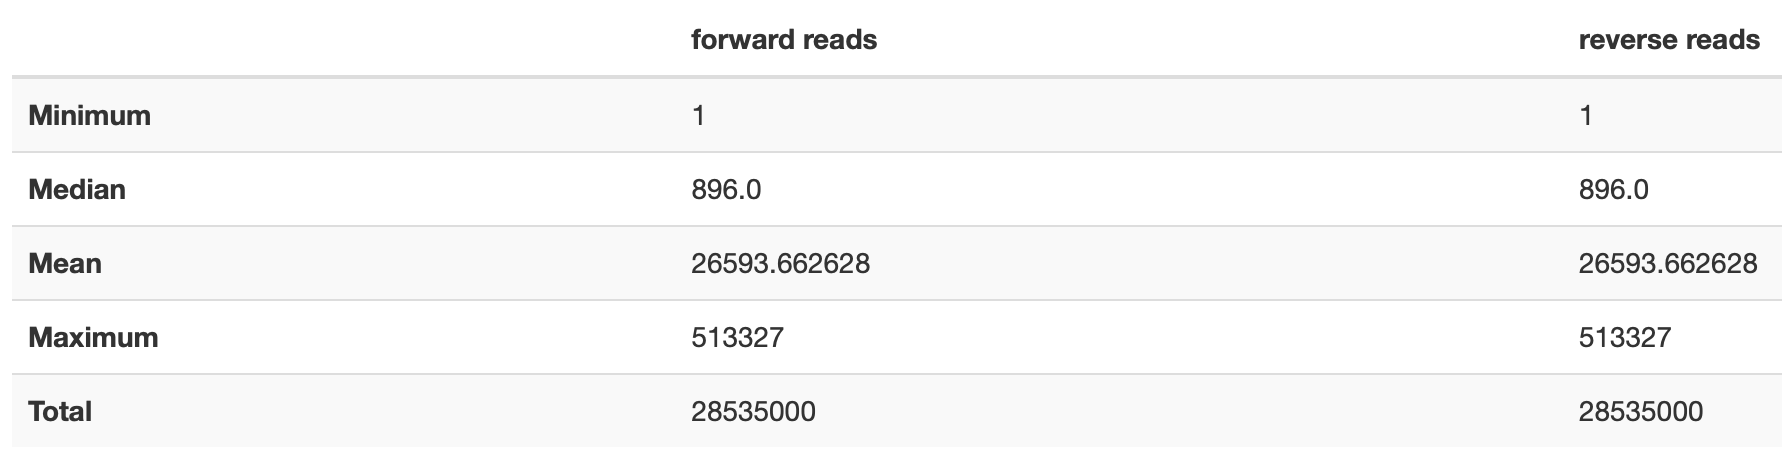

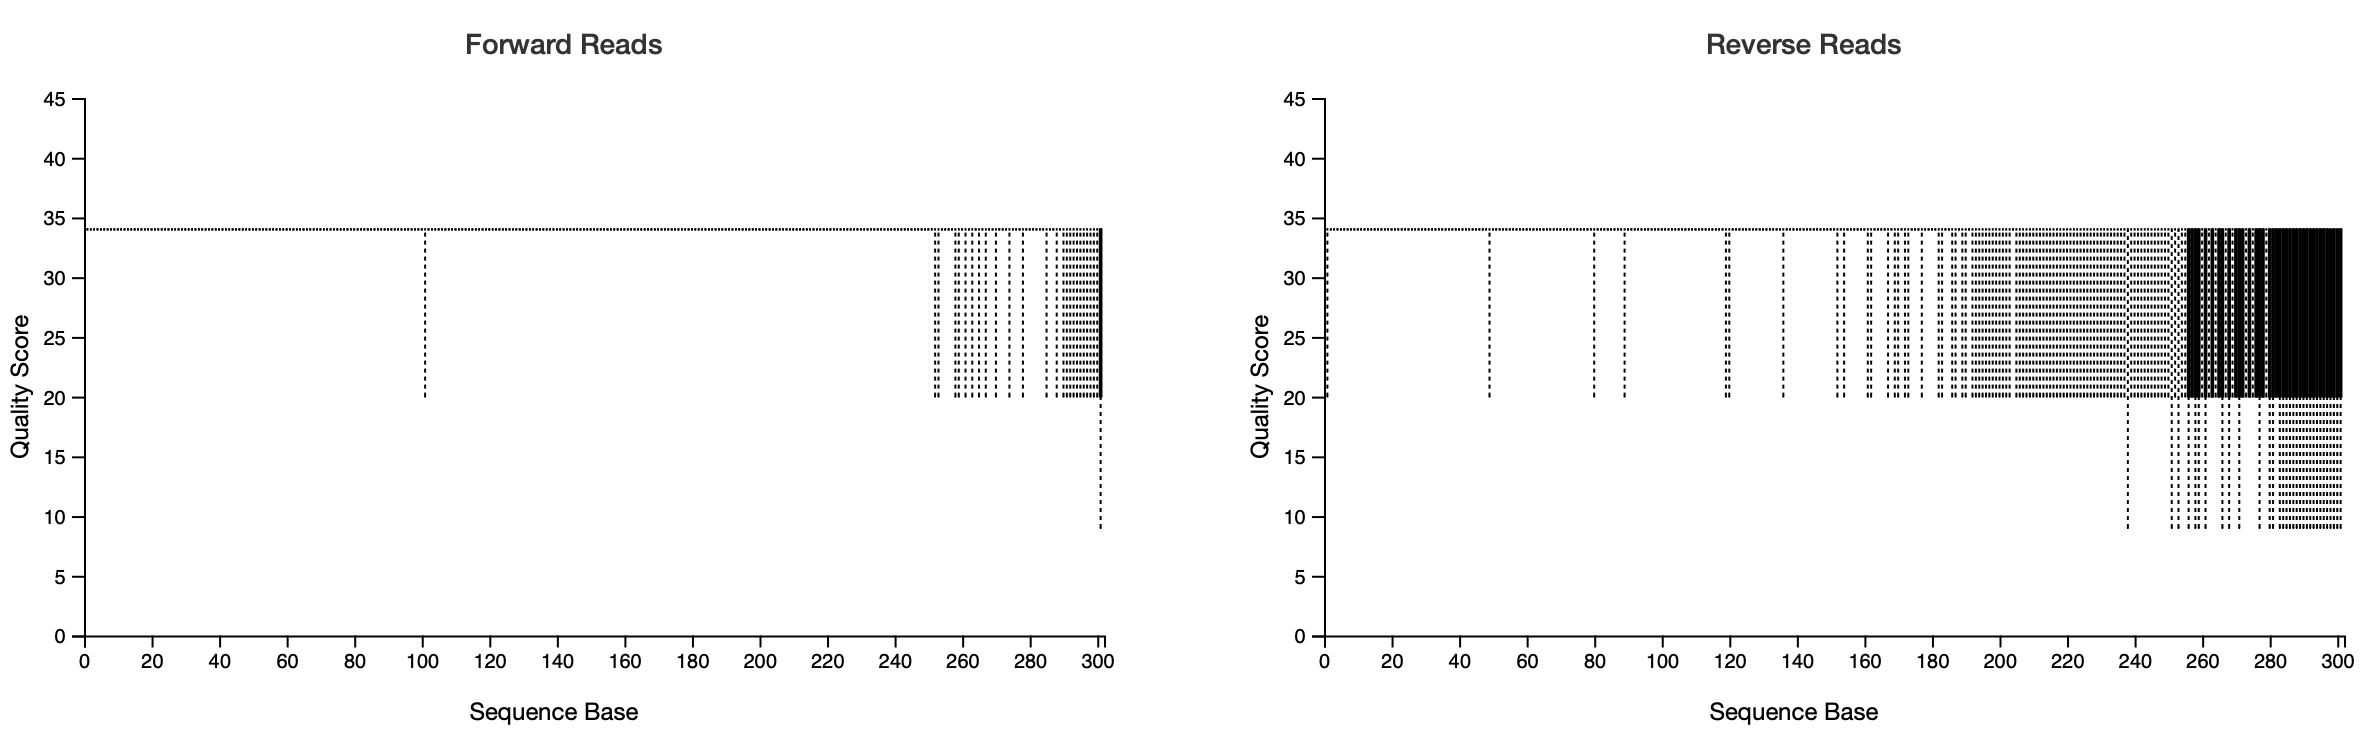

## ITS denoising

first: remove adapters that might be there due to read-throughs:

In [ ]:
qiime cutadapt trim-paired \
  --i-demultiplexed-sequences ITS/ITS-demux-paired-end.qza \
  --p-cores 10 \
  --p-front-f ACCTGCGGARGGATCA \  # Forward primer
  --p-front-r GAGATCCRTTGYTRAAAGTT \    # Reverse primer
  --p-adapter-f AACTTTAYRCAAYYGGATCTC \   # Reverse complement of reverse primer
  --p-adapter-r TGATCCTYCCGCAGGT \ # Reverse complement of forward primer
  --p-error-rate 0.2 \   # Allow up to 10% mismatches
  --o-trimmed-sequences ITS/ITS-demux-paired-end-trimmed.qza

qiime cutadapt trim-paired \
  --i-demultiplexed-sequences ITS/ITS-demux-paired-end.qza \
  --p-cores 10 \
  --p-front-f ACCTGCGGARGGATCA \
  --p-front-r GAGATCCRTTGYTRAAAGTT \
  --p-adapter-f AACTTTAYRCAAYYGGATCTC \
  --p-adapter-r TGATCCTYCCGCAGGT \
  --p-error-rate 0.2 \
  --o-trimmed-sequences ITS/ITS-demux-paired-end-trimmed.qza


qiime demux summarize \
  --i-data ITS/ITS-demux-paired-end-trimmed.qza \
  --o-visualization ITS/ITS-demux-paired-end-trimmed.qzv

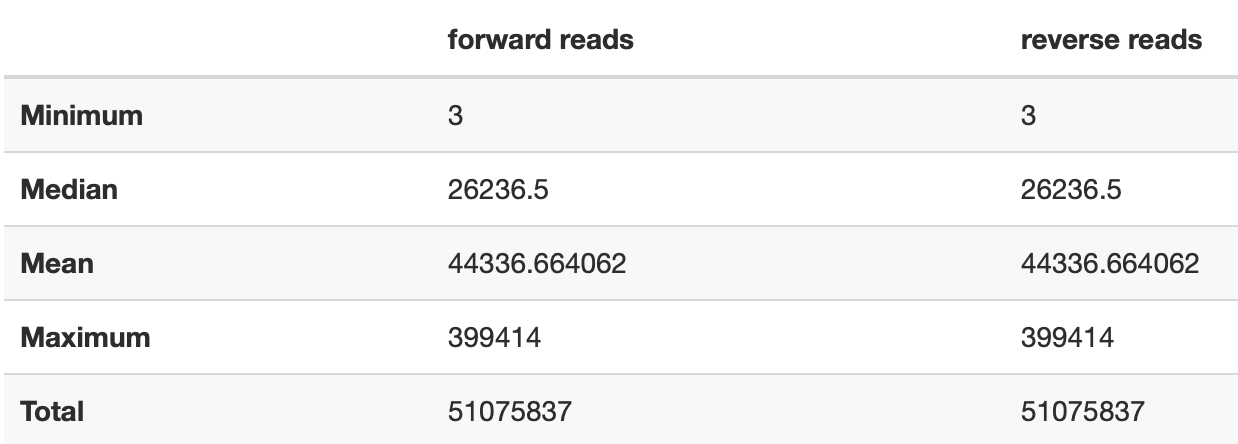

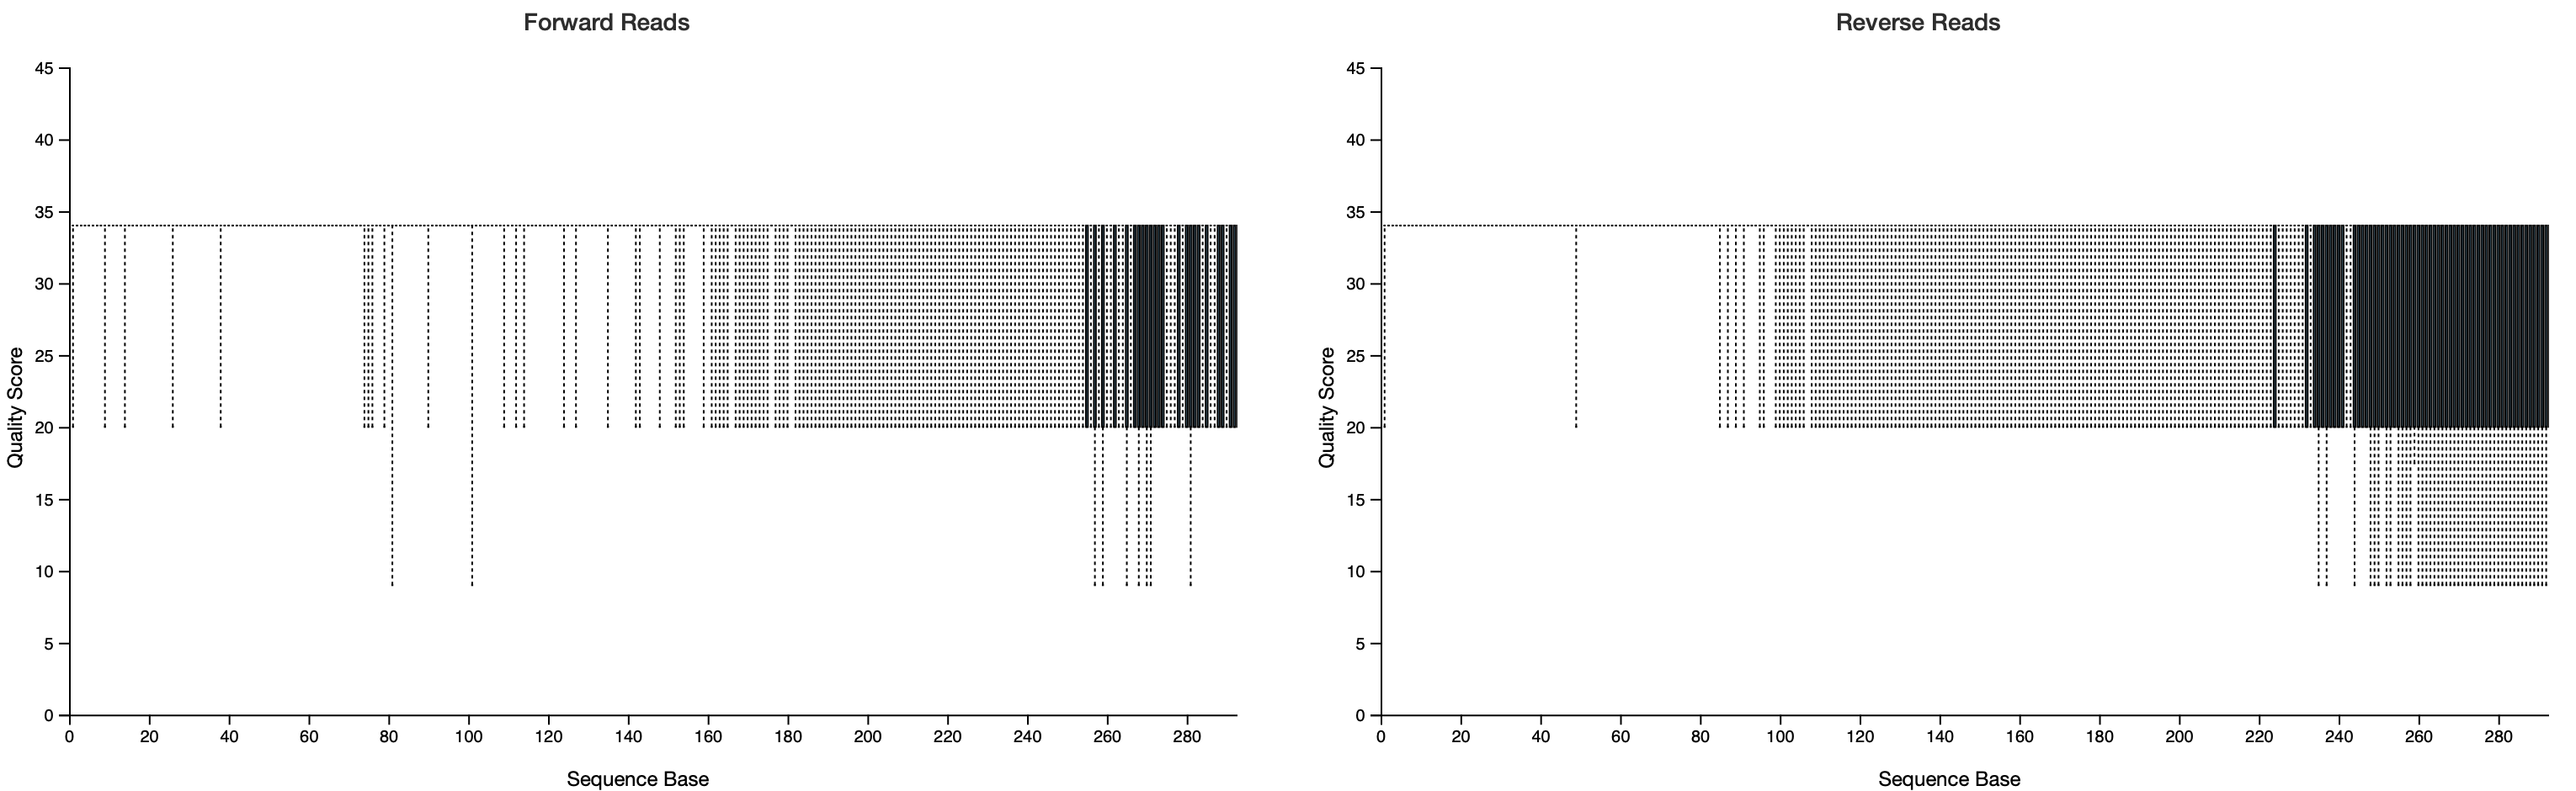

continue with denoising, only forward reads since this by experience retains more reads while also keeping really good quality overall:

In [ ]:
# fungal

qiime dada2 denoise-single \
--i-demultiplexed-seqs ITS/ITS-demux-paired-end-trimmed.qza \
--p-trunc-len 0 \
--p-n-threads 5 \
--p-max-ee 4.0 \
--p-min-fold-parent-over-abundance 4.0 \
--o-representative-sequences ITS/dada2/dada1-rep-seqs.qza \
--o-table ITS/dada2/dada1-table.qza \
--o-denoising-stats ITS/dada2/dada1-stats.qza

qiime metadata tabulate \
--m-input-file ITS/dada2/dada1-stats.qza \
--o-visualization ITS/dada2/dada1-stats.qzv

qiime feature-table summarize \
--i-table ITS/dada2/dada1-table.qza \
--o-visualization ITS/dada2/dada1-table.qzv

qiime feature-table tabulate-seqs \
  --i-data ITS/dada2/dada1-rep-seqs.qza \
  --o-visualization ITS/dada2/dada1-rep-seqs.qzv

## 16S denoising

Since the typical length for the amplicon 515F 806R is ~250 bp, try with 150 and 150 bp trims

In [ ]:
#bash:

# bacterial:

qiime dada2 denoise-paired \
--i-demultiplexed-seqs 16S/16S-demux-paired-end.qza \
--p-trunc-len-f 150 \
--p-trunc-len-r 150 \
--p-min-fold-parent-over-abundance 4.0 \
--p-n-threads 5 \
--o-representative-sequences 16S/dada2/dada2-rep-seqs.qza \
--o-table 16S/dada2/dada2-table.qza \
--o-denoising-stats 16S/dada2/dada2-stats.qza
qiime metadata tabulate \
--m-input-file 16S/dada2/dada2-stats.qza \
--o-visualization 16S/dada2/dada2-stats.qzv
qiime feature-table summarize \
--i-table 16S/dada2/dada2-table.qza \
--o-visualization 16S/dada2/dada2-table.qzv

qiime feature-table tabulate-seqs \
  --i-data 16S/dada2/dada2-rep-seqs.qza \
  --o-visualization 16S/dada2/dada2-rep-seqs.qzv

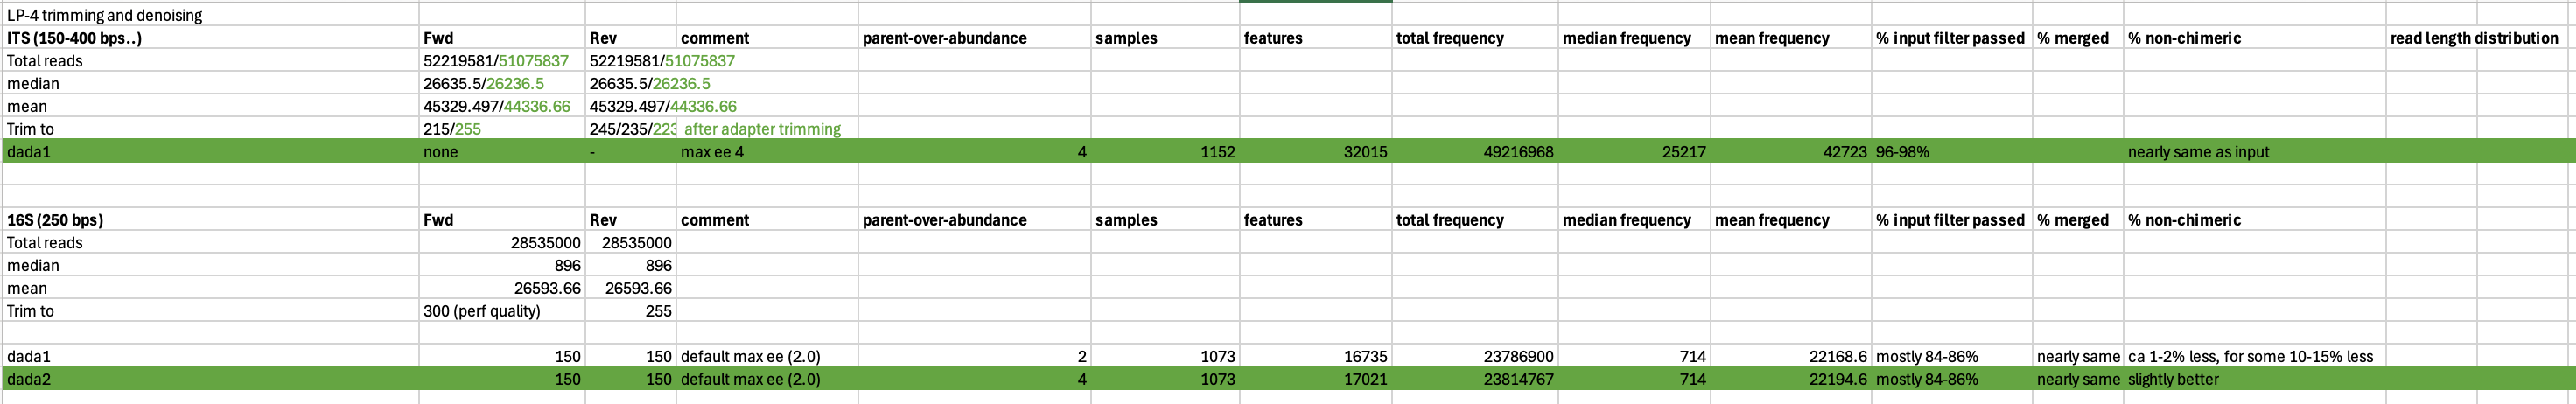